In [1]:
import matplotlib.pyplot as plt
import numpy as np


NUM_REACTIONS = 8


# species G, M, P, D, B
displacements = np.array([
    [0, 1, 0, 0, 0], # G -> G + M
    [0, 0, 1, 0, 0], # M -> M + P
    [0, -1, 0, 0, 0], # M -> {}
    [0, 0, -1, 0, 0], # P -> {}
    [0, 0, -2, 1, 0], # 2P -> D
    [0, 0, 0, -1, 0], # D -> {}
    [-1, 0, 0, -1, 1], # G + D -> B
    [1, 0, 0, 1, -1] # B -> G + D]
])

t_max = 10


def get_l_star(intensities):
    u = np.random.uniform(0, sum(intensities))
    running_total = 0
    for i, intensity in enumerate(intensities):
        running_total += intensity
        if u < running_total:
            return i


def G_inverse(l, r, s, X, k):
    intensity = get_intensities(X, k)[l]
    # We take the argmin over all the G^{-1} anyway. Otherwise we get a divide by zero exception.
    if intensity == 0:
        return np.infty

    return s + (r / intensity)


def get_intensities(X, k):
    # species G, M, P, D, B
    lambda_0 = k[0] * X[0]  # G -> G + M
    lambda_1 = k[1] * X[1]  # M -> M + P
    lambda_2 = k[2] * X[1]  # M -> {}
    lambda_3 = k[3] * X[2]  # P -> {}
    lambda_4 = k[4] * X[2] * (X[2] - 1)  # 2P -> D
    lambda_5 = k[5] * X[3]  # D -> {}
    lambda_6 = k[6] * X[0] * X[3]  # G + D -> B
    lambda_7 = k[7] * X[4]  # B -> G + D
    return np.array([lambda_0, lambda_1, lambda_2, lambda_3, lambda_4, lambda_5, lambda_6, lambda_7])

In [2]:
def next_reaction(X_0, S_0, T_1, tau_0, k):
    X = np.array(X_0)
    Xs = [X]
    S = np.array(S_0)
    T = np.array(T_1)
    tau = np.array(tau_0)

    # Since S_0 == [0] * NUM_PARTICLES anyway, l_star could be any index to start out with.
    l_star = 0
    s = S[l_star]

    x_axis = [0]
    y_axis = [[x] for x in X]

    while s < t_max:
        S = [G_inverse(l=l, r=T[l] - tau[l], s=s, X=X, k=k) for l in range(NUM_REACTIONS)]

        l_star = np.argmin(S)
        previous_s = s
        s = S[l_star]

        # Observe that $$\tau_{\ell}^{S_j} = \int_0^{S_j} \lambda_{\ell} (X_s) ds =
        # \sum_{m=0}^{j-1} (S_{m+1} - S_m) \lambda_{\ell}(X_m)$$ since $\{S_i\}$ are the jump times of $X_t$.
        # Hence $\tau$ accumulates in piece-wise sums, as an integral over a step function.
        # We may program this dynamically in the following way -
        # (Note that the expression tau += get_intensities(X=X, k=k) * (s - previous_s) throws a type error here in
        # > python 3.9)
        tau = tau + get_intensities(X=X, k=k) * (s - previous_s)

        X += displacements[l_star]
        Xs.append(X)

        T[l_star] -= np.log(np.random.uniform(low=0.0, high=1.0))

        x_axis.append(s)
        for i, x in enumerate(X):
            y_axis[i].append(x)

    plt.plot(x_axis, y_axis[0], label='G')
    plt.plot(x_axis, y_axis[1], label='M')
    plt.plot(x_axis, y_axis[2], label='P')
    plt.plot(x_axis, y_axis[3], label='D')
    plt.plot(x_axis, y_axis[4], label='B')
    plt.legend()
    plt.show()
    
    return np.array(Xs)

In [66]:
def gillespie(X_0, k, with_plot=True):
    X = np.array(X_0)
    Xs = [X]
    t = 0

    x_axis = [0]
    y_axis = [[x] for x in X]

    while t < t_max:
        intensities = get_intensities(X, k)
        r = np.random.exponential(1 / sum(intensities))
        t += r
        l_star = get_l_star(intensities)
        X += displacements[l_star]
        Xs.append(X)

        x_axis.append(t)
        for i, x in enumerate(X):
            y_axis[i].append(x)

    if with_plot:        
        plt.plot(x_axis, y_axis[0], label='G')
        plt.plot(x_axis, y_axis[1], label='M')
        plt.plot(x_axis, y_axis[2], label='P')
        plt.plot(x_axis, y_axis[3], label='D')
        plt.plot(x_axis, y_axis[4], label='B')
        plt.legend()
        plt.show()

    return np.array(Xs), np.array(x_axis), np.array(y_axis[2])

In [64]:
def tau_leaping(X_0, k, h, with_plot=True):
    X = np.array(X_0)
    Xs = [X]
    taus = np.zeros(NUM_REACTIONS)

    x_axis = []
    y_axis = [[] for _ in X]
    num_intervals = int(t_max / h)

    for n in range(num_intervals):
        x_axis.append(n)
        for i, x in enumerate(X):
            y_axis[i].append(x)

        taus += h * get_intensities(X=X, k=k)
        
        jumps = [np.random.poisson(taus[l]) * displacements[l] for l in range(NUM_REACTIONS)]

        total_jump = h * np.sum(jumps, axis=0)
        
        X = X + total_jump
        X = np.where(X < 0, 0, X)
        Xs.append(X)

    if with_plot:    
        plt.plot(x_axis, y_axis[0], label='G')
        plt.plot(x_axis, y_axis[1], label='M')
        plt.plot(x_axis, y_axis[2], label='P')
        plt.plot(x_axis, y_axis[3], label='D')
        plt.plot(x_axis, y_axis[4], label='B')
        plt.legend()
        plt.show()
    
    return np.array(Xs), np.array(x_axis)


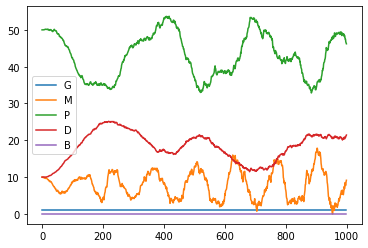

In [10]:
tau_Xs = tau_leaping(X_0=[1, 10, 50, 10, 0], k=[200, 10, 25, 1, 0.01, 1, 0, 0], h=0.01)

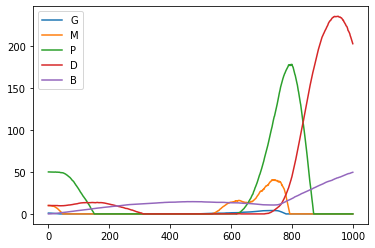

In [7]:
tau_leaping(X_0=[1, 10, 50, 10, 0], k=[200, 10, 25, 1, 0.01, 1, 2, 0.1], h=0.01)

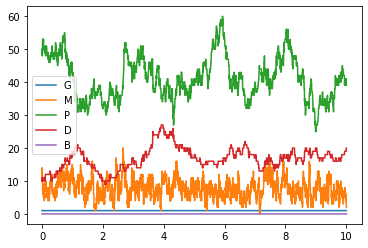

In [36]:
NR_Xs = next_reaction(
        X_0=[1, 10, 50, 10, 0],
        S_0=[0] * NUM_REACTIONS,
        T_1=[np.random.exponential() for _ in range(NUM_REACTIONS)],
        tau_0=[0] * NUM_REACTIONS,
        k=[200, 10, 25, 1, 0.01, 1, 0, 0])

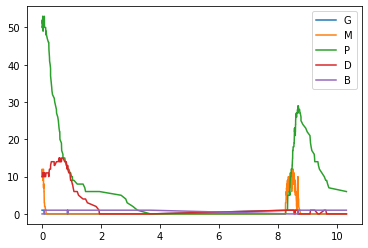

In [9]:
next_reaction(
        X_0=[1, 10, 50, 10, 0],
        S_0=[0] * NUM_REACTIONS,
        T_1=[np.random.exponential() for _ in range(NUM_REACTIONS)],
        tau_0=[0] * NUM_REACTIONS,
        k=[200, 10, 25, 1, 0.01, 1, 2, 0.1])

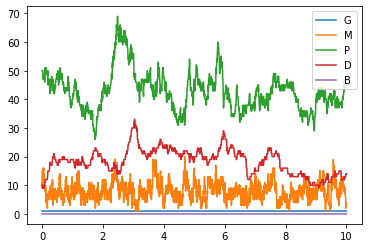

(array([[ 1,  4, 45, 14,  0],
        [ 1,  4, 45, 14,  0],
        [ 1,  4, 45, 14,  0],
        ...,
        [ 1,  4, 45, 14,  0],
        [ 1,  4, 45, 14,  0],
        [ 1,  4, 45, 14,  0]]),
 array([0.00000000e+00, 1.28213863e-03, 2.40117811e-03, ...,
        9.99060238e+00, 9.99158866e+00, 1.00004928e+01]))

In [48]:
gillespie(X_0=[1, 10, 50, 10, 0], k=[200, 10, 25, 1, 0.01, 1, 0, 0])

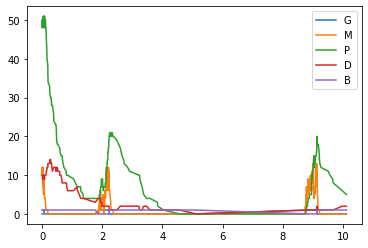

In [13]:
gillespie(X_0=[1, 10, 50, 10, 0], k=[200, 10, 25, 1, 0.01, 1, 2, 0.1])

In [40]:
np.abs(NR_Xs - tau_Xs)

ValueError: operands could not be broadcast together with shapes (5452,5) (1001,5) 

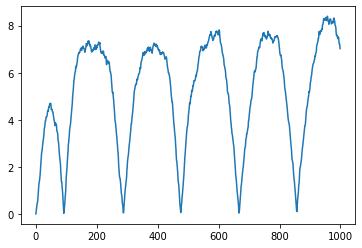

In [71]:
number_of_runs_for_average = 500
tau_p_cumulative_data = [[] for _ in range(1000)]
for _ in range(number_of_runs_for_average):
    tau_values, tau_x_axis = tau_leaping(X_0=[1, 10, 50, 10, 0], k=[200, 10, 25, 1, 0.01, 1, 0, 0], h=0.01, with_plot=False)
    for index in tau_x_axis:
        tau_p_value = tau_values[index][2]
        tau_p_cumulative_data[index].append(tau_p_value)
tau_p_averages = np.array([np.average(cumulative_data) for cumulative_data in tau_p_cumulative_data])  


gillespie_p_cumulative_data = [[] for _ in range(1000)]
for _ in range(number_of_runs_for_average):
    gillespie_Xs, gillespie_x_axis, gillespie_p_values = gillespie(X_0=[1, 10, 50, 10, 0], k=[200, 10, 25, 1, 0.01, 1, 0, 0], with_plot=False)
    gillespie_x_axis *= 100
    gillespie_interpolated_p_values = np.interp(tau_x_axis, gillespie_x_axis, gillespie_p_values)
    
    for index in tau_x_axis:
        gillespie_p_value = gillespie_interpolated_p_values[index]
        gillespie_p_cumulative_data[index].append(gillespie_p_value)
gillespie_p_averages = np.array([np.average(cumulative_data) for cumulative_data in gillespie_p_cumulative_data])    
plt.plot(tau_x_axis, abs(tau_p_averages - gillespie_p_averages))
plt.show()


    
